# Comparing total hydrostatic masses measured by LoCuSS and XGA

This notebook measures hydrostatic masses for the samples we are using to verify our method, then compares them to the measurements from literature. These mass measurements include both the baryonic content of the intra-cluster medium, and that of the dark matter halo. This implicitly tests how close our measured temperature and density profiles are to those measured by the work we compare them to

The LoCuSS sample has hydrostatic mass measurements associated with them which we will compare to but the XXL-100-GC sample data is generally too shallow for such measurements.

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError, Unit
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os
from tqdm import tqdm

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import locuss_colour, locuss_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 90
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.sourcetools.mass import inv_abel_dens_onion_temp
from xga.models import DoubleBetaProfile1D, SimpleVikhlininDensity1D, SimpleVikhlininTemperature1D

## Reading in Sample Files and Declaring XGA ClusterSamples

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### LoCuSS High-$L_{\rm{X}}$

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [2]:
locuss = pd.read_csv("../../sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [ ]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')

# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=False, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Setting up Galaxy Clusters:  60%|███████████████████████████                  | 27/45 [01:10<00:49,  2.74s/it]

## Reading in literature data

###  Hydrostatic masses from original work

In [ ]:
loc_lit_m500s = Quantity([locuss[locuss['name'] == n].iloc[0][['x_m500', 'x_m500_err', 'x_m500_err']].values 
                          for n in locuss_srcs.names], 'Msun')

loc_lit_m2500s = Quantity([locuss[locuss['name'] == n].iloc[0][['x_m2500', 'x_m2500_err', 'x_m2500_err']].values 
                           for n in locuss_srcs.names], 'Msun')


## Hydrostatic Mass Comparison to Literature

In [ ]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

In [ ]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

In [ ]:
demo_t_mod = SimpleVikhlininTemperature1D()
demo_t_mod.info()
demo_t_mod.par_priors

### Double Beta and Simplified Vikhlinin Density/Temperature Profiles - out to $R_{500}$, cnt$_{\rm{min}}$=3000

In [8]:
loc_sb_dblbeta_simpvikh_1_min3000_mp = inv_abel_dens_onion_temp(locuss_srcs, locuss_srcs.r500, 'double_beta', 
                                                                'double_king', 'simple_vikhlinin_temp', 
                                                                'r500', freeze_met=False, one_rmf=False,
                                                                temp_lo_en=Quantity(0.7, 'keV'), 
                                                                temp_hi_en=Quantity(10., 'keV'), 
                                                                temp_annulus_method='min_cnt', 
                                                                temp_min_cnt=Quantity(3000, 'ct'),
                                                                temp_use_combined=True, psf_bins=10)

Generating products of type(s) annular spectrum set components: 100%|█████| 390/390 [1:00:14<00:00,  9.27s/it]
Running XSPEC Fits: 100%|███████████████████████████████████████████████████| 444/444 [42:31<00:00,  5.75s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell1758N annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell2219 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.py:733: UserWarning: {s} doesn't have a matching projected temperature profile, skipping.
  warn("{s} doesn't have a matching projected temperature profile, skipping.")
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1068.19741761  975.3454814  1449.38684141 1111.55267906 1154.55333112
 1075.98046023]


Fitting data, inverse Abel transforming, and measuring densities:   5%|▍       | 2/42 [00:51<17:10, 25.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [711.3621144  565.75453275 992.67106341 867.78615837 893.25117065
 966.9276321 ]


Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 3/42 [01:15<16:18, 25.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1326.3595917   841.95744016 1354.27514207 1260.98425703 1336.74700972
 1350.05532427]


Fitting data, inverse Abel transforming, and measuring densities:  10%|▊       | 4/42 [01:38<15:18, 24.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1069.88975102 1520.73837161 2056.93269043 2121.28196291 2036.81572212
 2162.19979897]


Fitting data, inverse Abel transforming, and measuring densities:  12%|▉       | 5/42 [02:02<14:56, 24.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [590.08650943 785.33444969 299.18051794 239.77748736 405.83308312
 321.63116602]


Fitting data, inverse Abel transforming, and measuring densities:  19%|█▌      | 8/42 [03:20<14:25, 25.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 199.20744885  229.88444164 1498.74304933 1213.39984166 1304.0174705
 1250.42865348]


Fitting data, inverse Abel transforming, and measuring densities:  26%|█▊     | 11/42 [04:36<12:52, 24.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [322.32072956 602.68008997 927.30297934 303.7787447  214.62710509
 244.13709702]


Fitting data, inverse Abel transforming, and measuring densities:  29%|██     | 12/42 [05:04<12:58, 25.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1057.37140944 1092.34332419 1153.45877136 1082.44024351 1140.50045952
 1170.22931332]


Fitting data, inverse Abel transforming, and measuring densities:  31%|██▏    | 13/42 [05:29<12:24, 25.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 940.42388958  202.35367147  922.87807569  832.12402359  932.45364752
 1001.04388613]


Fitting data, inverse Abel transforming, and measuring densities:  33%|██▎    | 14/42 [05:55<12:01, 25.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1602.77282013  635.88593817 1761.06409932 1423.75780199 1598.21007666
 1790.28303833]


Fitting data, inverse Abel transforming, and measuring densities:  38%|██▋    | 16/42 [06:45<10:55, 25.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1139.36399999 1272.84557327 1934.72948943 1442.62822721 1859.28474188
 1899.07081921]


Fitting data, inverse Abel transforming, and measuring densities:  40%|██▊    | 17/42 [07:10<10:34, 25.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 606.08248193  444.30607827 1604.15980038 1163.40329365 1225.15906329
 1282.42609595]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [216.45171307 217.13585389 444.74122477 205.51301571 404.63326824
 454.93172655]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:614: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of Abell0781's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  48%|███▎   | 20/42 [08:29<09:36, 26.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [770.32840444 795.89612764 802.39996691 755.36630876 795.72997347
 813.96956235]


Fitting data, inverse Abel transforming, and measuring densities:  50%|███▌   | 21/42 [08:57<09:22, 26.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [431.09949648 453.58999265 423.18281812 340.46370413 369.3644001
 407.77448495]


Fitting data, inverse Abel transforming, and measuring densities:  52%|███▋   | 22/42 [09:26<09:07, 27.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 747.19656565  309.08281127 1861.30254522 1545.56540528 1366.78537882
 1845.49807206]


Fitting data, inverse Abel transforming, and measuring densities:  57%|████   | 24/42 [10:15<07:44, 25.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 872.36233114  498.34694041 1753.55078145  705.26695079  670.83117594
 1741.78436321]


Fitting data, inverse Abel transforming, and measuring densities:  62%|████▎  | 26/42 [11:09<07:02, 26.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 757.92802935  925.88969907 1657.79908175 1349.5270295  1111.48536153
 1207.9283962 ]


Fitting data, inverse Abel transforming, and measuring densities:  71%|█████  | 30/42 [12:54<05:10, 25.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 839.17579053 1059.21284253 2234.21185367 1187.08754979 1496.61524541
 2237.30480073]


Fitting data, inverse Abel transforming, and measuring densities:  74%|█████▏ | 31/42 [13:19<04:42, 25.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [400.3124991  570.63570357  84.51847402 695.85104729 711.22989573
  71.79397043]


Fitting data, inverse Abel transforming, and measuring densities:  76%|█████▎ | 32/42 [13:47<04:21, 26.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [686.53811903 613.53576067 752.27062046 810.57002902 803.51195503
 806.22453312]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▌| 39/42 [16:57<01:19, 26.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1413.3171798   924.91064873 1502.53717637 1383.54595508 1509.78756168
 1513.80040741]


Fitting data, inverse Abel transforming, and measuring densities:  98%|██████▊| 41/42 [17:47<00:25, 25.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1253.15925915 1428.11377305 1314.21255285 1408.52426702 1576.32969177
 1337.09600615]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 42/42 [18:11<00:00, 25.99s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 660.07128236  370.45780819 1457.14860831  887.69027526  398.03752027
 1294.81872588]


Generating Abell2697 hydrostatic mass profile:   0%|                                   | 0/45 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [652.20075404 881.56358899 354.55333907 777.63872942 333.90114707
 347.05021632]


Generating Abell0068 hydrostatic mass profile:   2%|▌                          | 1/45 [00:46<33:56, 46.29s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [847.70377462 863.32944517 867.80198325 638.99452851 720.59206717
 823.78818503]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [470.18095709 409.42910589 255.74579552 480.19171205 220.69142093
 210.25244842]


Generating Abell2813 hydrostatic mass profile:   4%|█▏                         | 2/45 [01:33<33:33, 46.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1065.11875697 1105.64743913 1216.31949414  809.79742897  991.34968764
 1181.90905338]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [682.40297289 884.38849154 394.85772385 868.7747494  312.86319394
 300.55506051]


Generating Abell0115S hydrostatic mass profile:   7%|█▋                        | 3/45 [02:20<32:44, 46.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1752.25149051 1770.15574883 1770.08873424 1514.53596749 1606.0174888
 1737.33316346]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [434.88307447 405.32849286 513.85590067 322.84532358 263.06463282
 316.57310352]


Generating Abell141 hydrostatic mass profile:   9%|██▍                         | 4/45 [03:04<31:16, 45.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1809.30049356 2102.96370661 2141.39925926 1742.32685714 1990.30313403
 2142.22381523]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 527.39540127 1681.14022436 1092.47351208  496.68838555  520.20716298
  567.26540285]


Generating ZwCl0104.4+0048 hydrostatic mass profile:  11%|██▎                  | 5/45 [03:48<30:09, 45.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [537.31427049 825.92301673 976.434293   512.99049526 457.00141177
 485.92789249]


Generating Abell0209 hydrostatic mass profile:  13%|███▌                       | 6/45 [04:35<29:37, 45.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [303.7417754  394.34067825 463.5393305  238.14733541 249.62388798
 227.90156176]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 348.13848796   87.73329553 1700.37877648  277.98462711  463.45052203
  454.18894369]


Generating Abell0267 hydrostatic mass profile:  16%|████▏                      | 7/45 [05:20<28:48, 45.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [478.36803376 627.23778313 734.95950627 452.17844699 399.8170787
 390.63711543]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
Generating Abell0291 hydrostatic mass profile:  18%|████▊                      | 8/45 [06:06<28:14, 45.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1125.67589772 1056.03056382  153.70541858  190.02270045  205.35307757
 1180.76772977]


Generating Abell0383 hydrostatic mass profile:  20%|█████▍                     | 9/45 [06:54<27:53, 46.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 983.39490517 1136.4535114  1061.61994385 1147.4883525   575.72888199
  668.25562819]


Generating Abell0521 hydrostatic mass profile:  22%|█████▊                    | 10/45 [07:44<27:38, 47.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [363.23301982 540.63801629 352.59918934 420.83644027 352.85311376
 264.61494134]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 970.43564376  882.26329973  808.30302868 1713.36398093 1787.95636717
 1403.99934413]


Generating Abell0586 hydrostatic mass profile:  24%|██████▎                   | 11/45 [08:24<25:37, 45.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [359.01469192 518.57131234 780.69884791 383.20340086 322.992448
 343.59773816]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [321.94716644 371.12811344 409.50125462 438.68487499 435.52346373
 414.22029543]


Generating Abell0611 hydrostatic mass profile:  27%|██████▉                   | 12/45 [09:13<25:31, 46.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 993.16365315 1153.31404303  550.64333153 1041.11109022  444.77031411
  470.30975386]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1730.8495793  1880.61817414  966.56489965 1716.99586125 1858.0860212
  971.12529334]


Generating Abell0697 hydrostatic mass profile:  29%|███████▌                  | 13/45 [09:56<24:13, 45.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [617.35512428 546.17522085 335.19664874 650.92843267 304.71305067
 236.93706292]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1714.59239943 1716.34281284 1691.15328938 1375.70739322 1506.35997185
 1662.37225999]


Generating ZwCl0857.9+2107 hydrostatic mass profile:  31%|██████▏             | 14/45 [10:44<23:54, 46.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [979.70205278 613.1843959  892.18212851 865.52603797 479.82028604
 743.38649773]


Generating Abell0750 hydrostatic mass profile:  33%|████████▋                 | 15/45 [11:27<22:34, 45.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2071.09784093 1982.06596341  693.41884444 1622.7627844  1595.88121871
  743.56598702]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 705.09517728 1239.96536168 1302.90992783  502.748622    318.75653718
  564.76605768]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2387.51124746 2011.10184445 2439.28260574 2014.5248804  1960.34037997
 2414.2614473 ]


Generating Abell0773 hydrostatic mass profile:  36%|█████████▏                | 16/45 [12:14<22:02, 45.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [816.94394947 901.19135555 393.59080635 868.83965701 360.23638384
 352.13875566]


Generating Abell0781 hydrostatic mass profile:  38%|█████████▊                | 17/45 [12:57<20:55, 44.83s/it]/tmp/ipykernel_121461/2519449106.py:1: UserWarning: The density profile for Abell0781 could not be generated
  loc_sb_dblbeta_simpvikh_1_min3000_mp = inv_abel_dens_onion_temp(locuss_srcs, locuss_srcs.r500, 'double_beta',
Generating Abell0901 hydrostatic mass profile:  40%|██████████▍               | 18/45 [12:57<20:10, 44.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2481.72619879 2578.69251839 1900.38558137 1968.12616092 2101.07911285
 1538.28193706]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 864.69584895 1155.43105219 1169.48646282  880.68690227  643.18675326
  382.47982673]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
Generating Abell0907 hydrostatic mass profile:  42%|██████████▉               | 19/45 [13:44<15:14, 35.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1359.04860586  484.28775797  207.18517459  339.88543054  576.00491261
 1195.96906234]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [310.58582074 419.13088059 466.96840612 257.59793336 218.45749472
 221.16319169]


Generating Abell0963 hydrostatic mass profile:  44%|███████████▌              | 20/45 [14:35<16:17, 39.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [409.7702417  631.9649455  598.7323442  528.7367704  339.49100937
 310.23430019]


Generating ZwCl1021.0+0426 hydrostatic mass profile:  47%|█████████▎          | 21/45 [15:23<16:28, 41.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1169.88894113 2187.93010598 2156.02128626 2083.55294017  940.50033306
 1727.58690554]


Generating Abell1451 hydrostatic mass profile:  49%|████████████▋             | 22/45 [16:10<16:28, 42.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [448.45942982 524.57571981 342.66996857 517.18489799 312.08836178
 263.35911339]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [777.57569429 837.09105851 600.58952114 733.7051395  721.69377686
 517.39867197]


Generating ZwCl1231.4+1007 hydrostatic mass profile:  51%|██████████▏         | 23/45 [16:57<16:10, 44.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2009.92795791 2062.72772891 1793.71973937 1627.14652335 1836.82146866
 1788.5699773 ]


Generating Abell1689 hydrostatic mass profile:  53%|█████████████▊            | 24/45 [17:44<15:39, 44.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 952.18666996 1096.98336561  606.47253343 1180.01694872  441.50596076
  508.95870438]


Generating Abell1763 hydrostatic mass profile:  58%|███████████████           | 26/45 [18:31<14:26, 45.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [563.6668629  756.58955412 367.87301223 668.35232069 317.59370004
 313.88564012]


Generating Abell1914 hydrostatic mass profile:  62%|████████████████▏         | 28/45 [19:15<09:52, 34.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2285.77563803 2274.08331029 1988.12576872 1789.98680839 2001.34093891
 2062.56638497]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [703.13109961 689.38338759 341.52948725 787.69711698 329.04546041
 296.38329398]


Generating ZwCl1454.8+2233 hydrostatic mass profile:  64%|████████████▉       | 29/45 [20:03<08:08, 30.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 710.96327898 1346.75760218 1238.73300361  880.85216193  446.07434783
  477.71021342]


Generating Abell2009 hydrostatic mass profile:  67%|█████████████████▎        | 30/45 [20:49<08:30, 34.04s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [758.90729406 813.02662749 535.94593995 881.9092041  411.95758977
 562.88671795]


Generating ZwCl1459.4+4240 hydrostatic mass profile:  69%|█████████████▊      | 31/45 [21:39<08:48, 37.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 785.66044153 1331.22755048  401.092403    979.70180201  418.52037224
  356.3403989 ]


Generating RXCJ1504.1-0248 hydrostatic mass profile:  71%|██████████████▏     | 32/45 [22:22<08:28, 39.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1146.04235657 1258.4555782  2191.62245211 2138.59837125 2117.66947644
 2200.74638519]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1741.92997361 2168.36944606 2148.97125661 2137.31439887  871.73004565
 1784.43563062]


Generating Abell2111 hydrostatic mass profile:  73%|███████████████████       | 33/45 [23:12<08:23, 41.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 519.83156741  702.97502577  431.43126232  705.32529693  361.26155228
 1850.74003873]


Generating Abell2204 hydrostatic mass profile:  76%|███████████████████▋      | 34/45 [23:58<07:53, 43.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [525.19371284 637.1392879  728.73705212 648.48675038 663.30015894
 638.80068399]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [569.96480445 614.01475283 592.08577577 605.3100872  283.15471864
 358.4931688 ]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [298.08673615 430.73499718 432.5868155  413.20774302 360.19759273
 396.69727943]


Generating RXJ1720.1+2638 hydrostatic mass profile:  80%|████████████████▊    | 36/45 [24:54<07:01, 46.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [740.70320154 597.24421721 644.56773375 586.50274055 356.31832864
 477.48597329]


Generating Abell2261 hydrostatic mass profile:  82%|█████████████████████▍    | 37/45 [25:44<04:56, 37.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [742.01745025 911.48624919 405.97955626 790.00156989 325.47557741
 461.89147158]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1416.78244007 1143.61698794  952.68306487  629.77736662 1010.13428975
 2251.76291121]


Generating RXCJ2102.1-2431 hydrostatic mass profile:  84%|████████████████▉   | 38/45 [26:31<04:35, 39.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [575.91067938 883.5620554  868.70046299 538.35975071 363.22615278
 346.76213538]


Generating RXJ2129.6+0005 hydrostatic mass profile:  87%|██████████████████▏  | 39/45 [27:16<04:05, 40.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1389.98497042 1437.56956409 2160.99560562  682.18891848 1473.18001553
 1950.04230308]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 961.5501066   983.44558468  954.44627717 1042.05634989  520.7031878
  657.72399285]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1586.08120103 2191.79774062 1854.79952438 1849.91780542 1641.76970619
 2018.99954359]


Generating Abell2390 hydrostatic mass profile:  89%|███████████████████████   | 40/45 [28:06<03:36, 43.20s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
Generating Abell2537 hydrostatic mass profile:  91%|███████████████████████▋  | 41/45 [28:51<02:55, 43.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 526.21905394  501.82861985  889.48281473 1359.17910706  852.85662807
  469.94024035]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [355.52132734 562.7237379  281.46874974 448.03762719 247.68976672
 289.53387022]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
Generating Abell2552 hydrostatic mass profile:  93%|████████████████████████▎ | 42/45 [29:37<02:13, 44.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [652.25615072 616.3477165  932.55339805 600.07556679 696.78380875
 864.19926465]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1012.59657039 1308.93716025  520.5546284  1202.55205914  430.69789084
  407.31122665]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
Generating Abell2631 hydrostatic mass profile:  96%|████████████████████████▊ | 43/45 [30:21<01:28, 44.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 889.1071987  1177.46318987 1319.35852422  945.36386384 1083.51335767
 1311.85037944]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [847.16754366 972.23290113 374.75557035 976.81612077 390.37563303
 291.51994553]


Generating Abell2645 hydrostatic mass profile:  98%|█████████████████████████▍| 44/45 [31:06<00:44, 44.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 980.93804776 1153.72598499 1342.1976751  1416.29183259  863.9619672
 1361.00793055]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [651.33624318 930.13811729 364.94437058 682.95032835 379.6328434
 340.11041969]


Complete: 100%|███████████████████████████████████████████████████████████████| 45/45 [31:52<00:00, 42.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [488.18144884 543.24818928 792.55745298 771.97584304 770.01739594
 837.49895852]


In [9]:
loc_sb_dblbeta_simpvikh_1_mc3000_m500 = []
loc_sb_dblbeta_simpvikh_1_mc3000_m2500 = []

with tqdm(desc='Measuring Masses for LoCuSS Clusters', total=len(loc_sb_dblbeta_simpvikh_1_min3000_mp)) as onwards:
    for mp in loc_sb_dblbeta_simpvikh_1_min3000_mp:
        if mp is not None:
            rel_src = locuss_srcs[mp.src_name]
            m = mp.mass(rel_src.r500)[0]
            if m[0] < Quantity(1e+13, 'Msun'):
                m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
                m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            else:
                m2500 = mp.mass(rel_src.r2500)[0]
        else:
            m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            
        loc_sb_dblbeta_simpvikh_1_mc3000_m500.append(m)
        loc_sb_dblbeta_simpvikh_1_mc3000_m2500.append(m2500)
        
        onwards.update(1)

loc_sb_dblbeta_simpvikh_1_mc3000_m500 = Quantity(loc_sb_dblbeta_simpvikh_1_mc3000_m500)
loc_sb_dblbeta_simpvikh_1_mc3000_m2500 = Quantity(loc_sb_dblbeta_simpvikh_1_mc3000_m2500)

Measuring Masses for LoCuSS Clusters: 100%|███████████████████████████████████| 45/45 [00:00<00:00, 55.23it/s]


In [10]:
print("{s} out of {t} R2500 mass measurements produced a "\
      "result".format(s=np.isfinite(loc_sb_dblbeta_simpvikh_1_mc3000_m2500[:, 0]).sum(), 
                      t=len(loc_sb_dblbeta_simpvikh_1_mc3000_m2500)))
print("{s} out of {t} R500 mass measurements produced a "\
      "result".format(s=np.isfinite(loc_sb_dblbeta_simpvikh_1_mc3000_m500[:, 0]).sum(), 
                      t=len(loc_sb_dblbeta_simpvikh_1_mc3000_m500)))

41 out of 45 R2500 mass measurements produced a result
41 out of 45 R500 mass measurements produced a result


In [11]:

np.isfinite(loc_lit_m500s[:, 0]).sum()

32

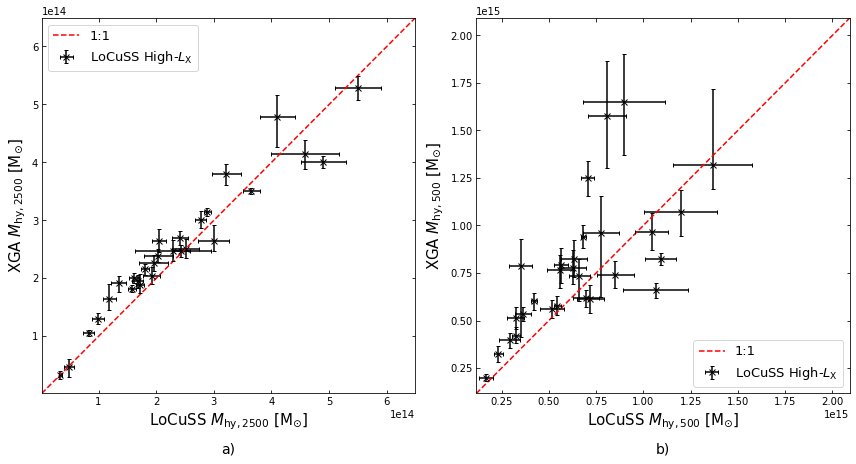

In [12]:
direct_comparison_plot([loc_lit_m2500s, loc_lit_m500s], 
                       [loc_sb_dblbeta_simpvikh_1_mc3000_m2500, loc_sb_dblbeta_simpvikh_1_mc3000_m500], 
                       [r"LoCuSS $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"XGA $M_{\rm{hy, 500}}$ [M$_{\odot}$]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6.5), ['linear', 'linear'], ['linear', 'linear'], 
                       savepath='../../outputs/figures/locuss_sb_dblbeta_simpvikh_1r500_mc3000_hymcomp.pdf')

100%|█████████████████████████████████████████████████████████████████| 20000/20000 [00:17<00:00, 1118.16it/s]


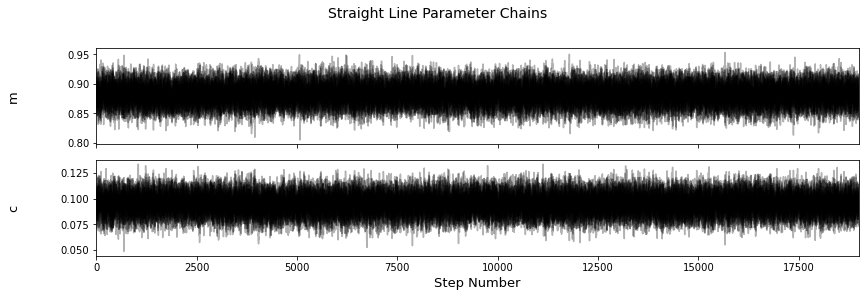

Removed no burn in


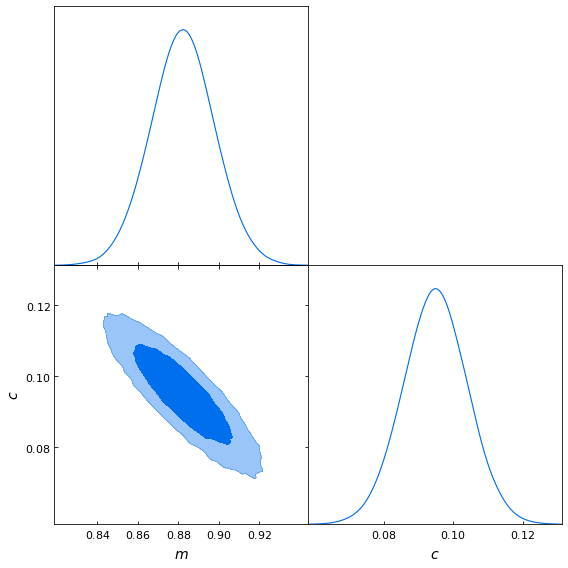

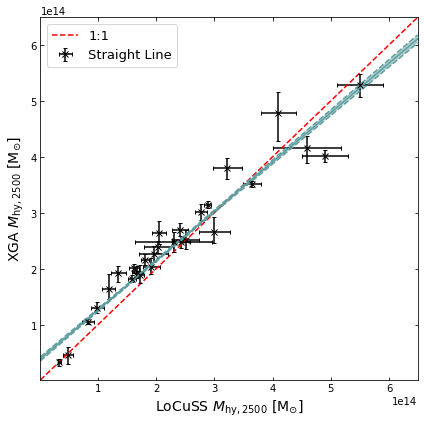

m=0.882 +0.016 -0.016 [1sig]
c=0.095 +0.009 -0.009 [1sig]


In [13]:
fit_comp(loc_lit_m2500s, loc_sb_dblbeta_simpvikh_1_mc3000_m2500, [[0, 100], [0, 5]], 
         r"LoCuSS $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", 
         r"XGA $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", Quantity(4e+14, 'Msun'),  num_steps=20000, view_chains=True, 
         linear=True, view_corner=True)


100%|█████████████████████████████████████████████████████████████████| 20000/20000 [00:17<00:00, 1118.78it/s]


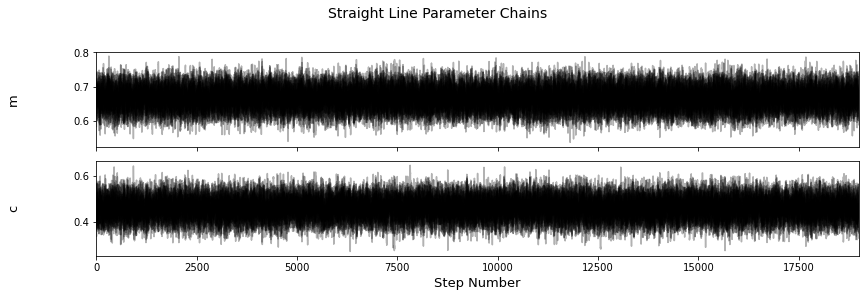

Removed no burn in


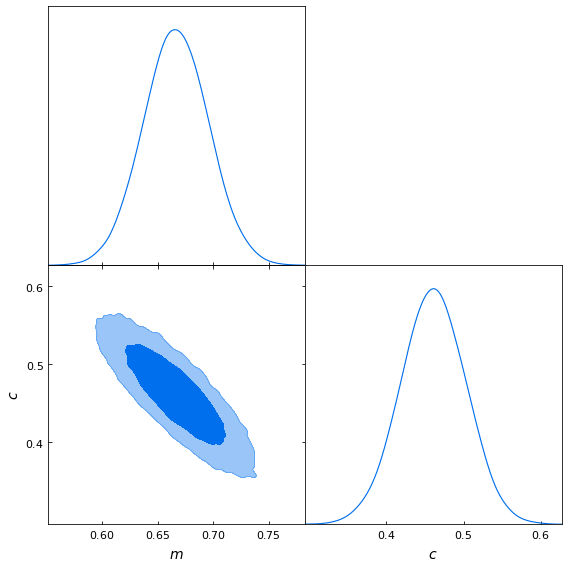

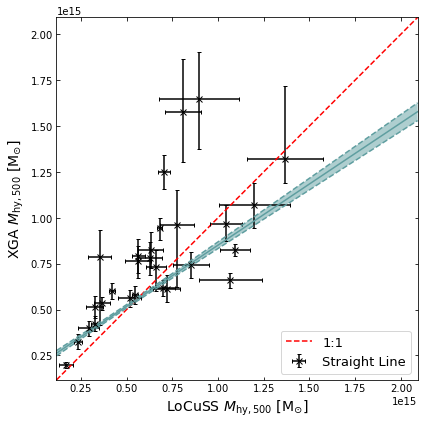

m=0.666 +0.03 -0.03 [1sig]
c=0.461 +0.042 -0.043 [1sig]


In [14]:
fit_comp(loc_lit_m500s, loc_sb_dblbeta_simpvikh_1_mc3000_m500, [[0, 100], [0, 5]], 
         r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]", 
         r"XGA $M_{\rm{hy, 500}}$ [M$_{\odot}$]", Quantity(4e+14, 'Msun'),  num_steps=20000, view_chains=True, 
         linear=True, view_corner=True)


## Outputting XGA measured results as a catalogue

We wish to write the hydrostatic masses to an easily readable format which can be version controlled:

In [20]:
loc_cols = ['name', 'Mhy500', 'Mhy500-', 'Mhy500+', 'Mhy2500', 'Mhy2500-', 'Mhy2500+']
loc_data = np.hstack([locuss_srcs.names[..., None], loc_sb_dblbeta_simpvikh_1_mc3000_m500.to('1e+14 Msun').value, 
                      loc_sb_dblbeta_simpvikh_1_mc3000_m2500.to('1e+14 Msun').value])
loc_df = pd.DataFrame(loc_data, columns=loc_cols)
loc_df.to_csv('../../outputs/results/locuss_masses.csv', index=False)
loc_df.head(10)

,name,Mhy500,Mhy500-,Mhy500+,Mhy2500,Mhy2500-,Mhy2500+
0,Abell2697,7.7864798382313865,0.8806131798698263,0.9154190353640227,2.4732444449817006,0.10067391539467876,0.10814726915520095
1,Abell0068,9.680842899770255,0.9706473916933639,0.9945891375586764,3.7932633419176818,0.18286390521534565,0.18216934176310878
2,Abell2813,8.223580615749508,0.9505952667095439,1.00096011605396,2.3883383081968668,0.10418822390027752,0.11103348256483533
3,Abell0115S,4.190734999082242,0.38771035680049193,0.4665113756082851,0.4641774846028793,0.1655106871687815,0.14692312467903204
4,Abell141,4.9147454161096205,0.3199037768614863,0.3662186649993357,0.38434696175941613,0.1439406795380801,0.08880142647773143
5,ZwCl0104.4+0048,3.378600137918238,0.24251109446725755,0.2538583182690594,0.803977525946222,0.028432766931052504,0.03629807328702969
6,Abell0209,5.773582048120491,0.4845740003811232,0.5242558402394039,1.893681133423124,0.14390438642168346,0.17975047749062972
7,Abell0267,8.863378308501522,0.9666676511510939,0.9985874291263251,2.1840897570186555,0.13540192600293657,0.19569026723860347
8,Abell0291,3.989105659126618,0.4093600627720063,0.3665442985030632,1.3012649374838607,0.09671157079986423,0.1056524010795447
9,Abell0383,5.145686974316884,0.5988561866393826,0.5854509226322814,2.010708496695416,0.08209476831656345,0.08235590630247032
